# Collusion-Breaking Mechanisms in RL Duopoly

This notebook implements and compares 4 mechanisms for breaking tacit collusion in a duopoly market with RL agents:

1. **Price Transparency with Noise Injection**: Add structured noise to observed competitor prices during training
2. **Demand Shock Amplification**: Increase market volatility to prevent convergence to collusive prices
3. **Exploration Decay Mismatch**: Asymmetric epsilon decay schedules to prevent agent synchronization
4. **Information Asymmetry**: Reveal one agent's cost structure but hide the other's

Each mechanism is evaluated on:
- Average prices (lower = more competitive)
- Price correlation (lower = less coordinated)
- Individual profits (divergence = breakup of collusion)
- Conformal auditor collusion score

In [3]:
import sys, os
import numpy as np
sys.path.append(os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
from market_core import DuopolyEnv
from utils import run_episode, plot_generalized_convergence, plot_market_shares
from agent_zoo import RLAgent, ConstrainedRLAgent
import copy
from collections import deque

C:\Users\tarih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Base Configuration

Define the static market environment and baseline RL agent parameters.

In [4]:
# Environment configuration (static market)
env_config = {
    'market_mode': 'static',
    'production_costs': [1.0, 2.0],
    'quality': [5.0, 5.0],
    'price_sensitivity': 0.8,
    'max_price': 6.0,
    'cost_std': 0.0,
    'max_steps': 2000  # Reduced for faster experiments
}

# Baseline RL configuration
rl_config = {
    'state_dim': 5,
    'hidden_dim': 128,
    'n_bins': 100,
    'lr': 5e-5,
    'gamma': 0.99,
    'epsilon': 1.0,
    'epsilon_decay': 0.99,
    'epsilon_min': 0.01,
    'batch_size': 64,
    'memory_size': 2000,
}

## Mechanism 1: Price Transparency with Noise Injection

Add structured noise to observed competitor prices during training to disrupt common knowledge of pricing behavior.

In [5]:
class NoisyObservationWrapper:
    """Wraps an environment to add noise to competitor prices in observations."""
    def __init__(self, env, noise_std=0.1, seed=None):
        self.env = env
        self.noise_std = noise_std
        self.rng = np.random.RandomState(seed)
        
    def reset(self, seed=None, options=None):
        return self.env.reset(seed=seed, options=options)
    
    def step(self, actions):
        state, rewards, done, truncated, info = self.env.step(actions)
        
        # Add noise to competitor price in observation (index 1)
        if self.noise_std > 0:
            noisy_state = state.copy()
            noisy_state[1] += self.rng.normal(0, self.noise_std)
            noisy_state[1] = np.clip(noisy_state[1], 0, self.env.max_price)
            return noisy_state, rewards, done, truncated, info
        
        return state, rewards, done, truncated, info
    
    def __getattr__(self, name):
        return getattr(self.env, name)

# Test Mechanism 1
print("=" * 60)
print("MECHANISM 1: PRICE TRANSPARENCY WITH NOISE INJECTION")
print("=" * 60)

env_m1 = DuopolyEnv(config=dict(env_config))
env_m1_noisy = NoisyObservationWrapper(env_m1, noise_std=0.15)

a1_m1 = RLAgent(env_m1.action_space, config=dict(rl_config))
a2_m1 = RLAgent(env_m1.action_space, config=dict(rl_config))

# Custom run_episode function to use noisy environment
def run_episode_custom_env(env, agent1, agent2, label, train_mode=True):
    """Modified run_episode that accepts a custom environment."""
    state, _ = env.reset()
    done = False
    history = []
    
    if hasattr(agent1, 'train') and hasattr(agent1, 'eval'):
        if train_mode: agent1.train()
        else: agent1.eval()
    if hasattr(agent2, 'train') and hasattr(agent2, 'eval'):
        if train_mode: agent2.train()
        else: agent2.eval()
    
    step_count = 0
    while not done:
        a1 = agent1.act(state)
        a2 = agent2.act(state)
        
        next_state, rewards, done, _, info = env.step([a1, a2])
        
        if train_mode:
            agent1.update((state, a1, rewards[0], next_state, done))
            agent2.update((state, a2, rewards[1], next_state, done))
        
        history.append({
            'step': step_count,
            'label': label,
            'p1': a1,
            'p2': a2,
            'r1': rewards[0],
            'r2': rewards[1],
        })
        
        state = next_state
        step_count += 1
    
    return pd.DataFrame(history)

print("\nTraining with noisy observations...")
hist_m1_train = run_episode_custom_env(env_m1_noisy, a1_m1, a2_m1, 'M1_train', train_mode=True)
print("Evaluating with clean observations (testing robustness)...")
hist_m1_eval = run_episode_custom_env(env_m1, a1_m1, a2_m1, 'M1_eval', train_mode=False)

print(f"\nM1 Results:")
print(f"  Train - Avg P1: {hist_m1_train['p1'].mean():.3f}, Avg P2: {hist_m1_train['p2'].mean():.3f}")
print(f"  Eval  - Avg P1: {hist_m1_eval['p1'].mean():.3f}, Avg P2: {hist_m1_eval['p2'].mean():.3f}")
print(f"  Price Correlation (Eval): {np.corrcoef(hist_m1_eval['p1'], hist_m1_eval['p2'])[0,1]:.3f}")

MECHANISM 1: PRICE TRANSPARENCY WITH NOISE INJECTION


C:\Users\tarih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\tarih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



Training with noisy observations...
Evaluating with clean observations (testing robustness)...

M1 Results:
  Train - Avg P1: 3.630, Avg P2: 4.114
  Eval  - Avg P1: 3.576, Avg P2: 4.061
  Price Correlation (Eval): 0.000


## Mechanism 2: Demand Shock Amplification

Increase market volatility during training to prevent convergence to stable collusive prices.

In [6]:
print("\n" + "=" * 60)
print("MECHANISM 2: DEMAND SHOCK AMPLIFICATION")
print("=" * 60)

# Create high-volatility market config
env_config_m2 = dict(env_config)
env_config_m2['market_mode'] = 'ar_drift'
env_config_m2['demand_shock_std'] = 0.5  # High volatility
env_config_m2['demand_shock_phi'] = 0.5  # Lower persistence = less predictable

env_m2 = DuopolyEnv(config=env_config_m2)

a1_m2 = RLAgent(env_m2.action_space, config=dict(rl_config))
a2_m2 = RLAgent(env_m2.action_space, config=dict(rl_config))

print("\nTraining in high-volatility market...")
hist_m2_train = run_episode_custom_env(env_m2, a1_m2, a2_m2, 'M2_train', train_mode=True)
print("Evaluating in static market (testing transfer)...")

env_m2_eval = DuopolyEnv(config=dict(env_config))  # Switch to static
hist_m2_eval = run_episode_custom_env(env_m2_eval, a1_m2, a2_m2, 'M2_eval', train_mode=False)

print(f"\nM2 Results:")
print(f"  Train (volatile) - Avg P1: {hist_m2_train['p1'].mean():.3f}, Avg P2: {hist_m2_train['p2'].mean():.3f}")
print(f"  Eval  (static)   - Avg P1: {hist_m2_eval['p1'].mean():.3f}, Avg P2: {hist_m2_eval['p2'].mean():.3f}")
print(f"  Price Correlation (Eval): {np.corrcoef(hist_m2_eval['p1'], hist_m2_eval['p2'])[0,1]:.3f}")
print(f"  Train price std (Agent 1): {hist_m2_train['p1'].std():.3f}")


MECHANISM 2: DEMAND SHOCK AMPLIFICATION

Training in high-volatility market...


C:\Users\tarih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\tarih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Evaluating in static market (testing transfer)...

M2 Results:
  Train (volatile) - Avg P1: 3.958, Avg P2: 4.381
  Eval  (static)   - Avg P1: 4.182, Avg P2: 4.424
  Price Correlation (Eval): -1.000
  Train price std (Agent 1): 0.678


## Mechanism 3: Exploration Decay Mismatch

Force agents to use asymmetric epsilon decay schedules to prevent synchronized convergence to collusive equilibrium.

In [7]:
print("\n" + "=" * 60)
print("MECHANISM 3: EXPLORATION DECAY MISMATCH (ASYMMETRIC EPSILON)")
print("=" * 60)

env_m3 = DuopolyEnv(config=dict(env_config))

# Agent 1: Fast decay (greedy quickly)
config_a1_m3 = dict(rl_config)
config_a1_m3['epsilon_decay'] = 0.985  # Fast decay

# Agent 2: Slow decay (exploratory for longer)
config_a2_m3 = dict(rl_config)
config_a2_m3['epsilon_decay'] = 0.995  # Slow decay

a1_m3 = RLAgent(env_m3.action_space, config=config_a1_m3)
a2_m3 = RLAgent(env_m3.action_space, config=config_a2_m3)

print("\nAgent 1 epsilon_decay: 0.985 (fast decay)")
print("Agent 2 epsilon_decay: 0.995 (slow decay)")
print("Training with mismatched exploration rates...")

hist_m3_train = run_episode_custom_env(env_m3, a1_m3, a2_m3, 'M3_train', train_mode=True)
print("Evaluating...")
hist_m3_eval = run_episode_custom_env(env_m3, a1_m3, a2_m3, 'M3_eval', train_mode=False)

print(f"\nM3 Results:")
print(f"  Train - Avg P1: {hist_m3_train['p1'].mean():.3f}, Avg P2: {hist_m3_train['p2'].mean():.3f}")
print(f"  Eval  - Avg P1: {hist_m3_eval['p1'].mean():.3f}, Avg P2: {hist_m3_eval['p2'].mean():.3f}")
print(f"  Price Correlation (Eval): {np.corrcoef(hist_m3_eval['p1'], hist_m3_eval['p2'])[0,1]:.3f}")


MECHANISM 3: EXPLORATION DECAY MISMATCH (ASYMMETRIC EPSILON)

Agent 1 epsilon_decay: 0.985 (fast decay)
Agent 2 epsilon_decay: 0.995 (slow decay)
Training with mismatched exploration rates...
Evaluating...

M3 Results:
  Train - Avg P1: 3.391, Avg P2: 4.044
  Eval  - Avg P1: 3.393, Avg P2: 4.303
  Price Correlation (Eval): 0.803


## Mechanism 4: Information Asymmetry with Cost Signaling

Reveal one agent's cost structure but hide the other's, breaking symmetric Nash equilibrium.

In [8]:
class InfoAsymmetryWrapper:
    """Wraps environment to provide asymmetric cost information to agents."""
    def __init__(self, env, agent_id=1, hide_from_agent=2):
        """
        agent_id: Which agent sees full info (1 or 2)
        hide_from_agent: Which agent has hidden cost info
        """
        self.env = env
        self.agent_id = agent_id  # Agent who sees both costs
        self.hide_from_agent = hide_from_agent  # Agent who doesn't see competitor cost
        
    def reset(self, seed=None, options=None):
        return self.env.reset(seed=seed, options=options)
    
    def get_state_for_agent(self, state, agent_id):
        """Modify state observation based on agent."""
        modified_state = state.copy()
        
        if agent_id == self.hide_from_agent:
            # This agent doesn't see competitor's cost
            # State format: [p1_t-1, p2_t-1, signal, c1, c2]
            # Hide c1 if agent 2, hide c2 if agent 1
            if agent_id == 2:
                modified_state[3] = 0  # Hide c1
            else:
                modified_state[4] = 0  # Hide c2
        
        return modified_state
    
    def step(self, actions):
        # Call parent step
        state, rewards, done, truncated, info = self.env.step(actions)
        
        # The environment returns one state, but we'll modify observations
        # For this wrapper, we'll just modify the info dict
        info['state_for_agent_1'] = self.get_state_for_agent(state, 1)
        info['state_for_agent_2'] = self.get_state_for_agent(state, 2)
        
        return state, rewards, done, truncated, info
    
    def __getattr__(self, name):
        return getattr(self.env, name)

def run_episode_asymmetric_info(env, agent1, agent2, agent_id1=1, agent_id2=2, label="", train_mode=True):
    """Run episode with asymmetric information."""
    state, _ = env.reset()
    done = False
    history = []
    
    if hasattr(agent1, 'train') and hasattr(agent1, 'eval'):
        if train_mode: agent1.train()
        else: agent1.eval()
    if hasattr(agent2, 'train') and hasattr(agent2, 'eval'):
        if train_mode: agent2.train()
        else: agent2.eval()
    
    step_count = 0
    while not done:
        # Get agent-specific observations
        state1 = env.get_state_for_agent(state, agent_id1) if hasattr(env, 'get_state_for_agent') else state
        state2 = env.get_state_for_agent(state, agent_id2) if hasattr(env, 'get_state_for_agent') else state
        
        a1 = agent1.act(state1)
        a2 = agent2.act(state2)
        
        next_state, rewards, done, _, info = env.step([a1, a2])
        
        if train_mode:
            agent1.update((state1, a1, rewards[0], next_state, done))
            agent2.update((state2, a2, rewards[1], next_state, done))
        
        history.append({
            'step': step_count,
            'label': label,
            'p1': a1,
            'p2': a2,
            'r1': rewards[0],
            'r2': rewards[1],
        })
        
        state = next_state
        step_count += 1
    
    return pd.DataFrame(history)

print("\n" + "=" * 60)
print("MECHANISM 4: INFORMATION ASYMMETRY (HIDDEN COSTS)")
print("=" * 60)

env_m4 = InfoAsymmetryWrapper(DuopolyEnv(config=dict(env_config)), agent_id=1, hide_from_agent=2)

a1_m4 = RLAgent(env_m4.env.action_space, config=dict(rl_config))
a2_m4 = RLAgent(env_m4.env.action_space, config=dict(rl_config))

print("\nAgent 1: Sees BOTH costs (c1 and c2)")
print("Agent 2: Only sees own cost (c2=2.0), c1 hidden")
print("Training with asymmetric information...")

hist_m4_train = run_episode_asymmetric_info(env_m4, a1_m4, a2_m4, agent_id1=1, agent_id2=2, label='M4_train', train_mode=True)
print("Evaluating (still asymmetric)...")
hist_m4_eval = run_episode_asymmetric_info(env_m4, a1_m4, a2_m4, agent_id1=1, agent_id2=2, label='M4_eval', train_mode=False)

print(f"\nM4 Results:")
print(f"  Train - Avg P1: {hist_m4_train['p1'].mean():.3f}, Avg P2: {hist_m4_train['p2'].mean():.3f}")
print(f"  Eval  - Avg P1: {hist_m4_eval['p1'].mean():.3f}, Avg P2: {hist_m4_eval['p2'].mean():.3f}")
print(f"  Price Correlation (Eval): {np.corrcoef(hist_m4_eval['p1'], hist_m4_eval['p2'])[0,1]:.3f}")
print(f"  Profit difference (Eval): {abs(hist_m4_eval['r1'].mean() - hist_m4_eval['r2'].mean()):.3f}")


MECHANISM 4: INFORMATION ASYMMETRY (HIDDEN COSTS)

Agent 1: Sees BOTH costs (c1 and c2)
Agent 2: Only sees own cost (c2=2.0), c1 hidden
Training with asymmetric information...
Evaluating (still asymmetric)...

M4 Results:
  Train - Avg P1: 4.042, Avg P2: 4.696
  Eval  - Avg P1: 5.212, Avg P2: 5.515
  Price Correlation (Eval): -1.000
  Profit difference (Eval): 0.654


## Baseline: Standard RL vs RL (No Collusion-Breaking)

Run a baseline where two agents learn without any mechanism to compare against.

In [9]:
print("\n" + "=" * 60)
print("BASELINE: STANDARD RL vs RL (NO INTERVENTION)")
print("=" * 60)

env_baseline = DuopolyEnv(config=dict(env_config))
a1_baseline = RLAgent(env_baseline.action_space, config=dict(rl_config))
a2_baseline = RLAgent(env_baseline.action_space, config=dict(rl_config))

print("\nTraining baseline agents...")
hist_baseline_train = run_episode_custom_env(env_baseline, a1_baseline, a2_baseline, 'Baseline_train', train_mode=True)
print("Evaluating baseline agents...")
hist_baseline_eval = run_episode_custom_env(env_baseline, a1_baseline, a2_baseline, 'Baseline_eval', train_mode=False)

print(f"\nBaseline Results:")
print(f"  Train - Avg P1: {hist_baseline_train['p1'].mean():.3f}, Avg P2: {hist_baseline_train['p2'].mean():.3f}")
print(f"  Eval  - Avg P1: {hist_baseline_eval['p1'].mean():.3f}, Avg P2: {hist_baseline_eval['p2'].mean():.3f}")
print(f"  Price Correlation (Eval): {np.corrcoef(hist_baseline_eval['p1'], hist_baseline_eval['p2'])[0,1]:.3f}")
print(f"  Avg Profit P1 (Eval): {hist_baseline_eval['r1'].mean():.3f}, P2: {hist_baseline_eval['r2'].mean():.3f}")


BASELINE: STANDARD RL vs RL (NO INTERVENTION)

Training baseline agents...
Evaluating baseline agents...

Baseline Results:
  Train - Avg P1: 3.962, Avg P2: 3.827
  Eval  - Avg P1: 3.940, Avg P2: 3.818
  Price Correlation (Eval): -0.000
  Avg Profit P1 (Eval): 1.301, P2: 0.887


## Comparative Analysis

Summarize and visualize the effectiveness of each mechanism across key metrics.

In [10]:
# Aggregate results
results_summary = {
    'Mechanism': ['Baseline', 'M1: Noise', 'M2: Shock', 'M3: Mismatch', 'M4: AsymInfo'],
    'Avg_Price_1': [
        hist_baseline_eval['p1'].mean(),
        hist_m1_eval['p1'].mean(),
        hist_m2_eval['p1'].mean(),
        hist_m3_eval['p1'].mean(),
        hist_m4_eval['p1'].mean(),
    ],
    'Avg_Price_2': [
        hist_baseline_eval['p2'].mean(),
        hist_m1_eval['p2'].mean(),
        hist_m2_eval['p2'].mean(),
        hist_m3_eval['p2'].mean(),
        hist_m4_eval['p2'].mean(),
    ],
    'Price_Correlation': [
        np.corrcoef(hist_baseline_eval['p1'], hist_baseline_eval['p2'])[0,1],
        np.corrcoef(hist_m1_eval['p1'], hist_m1_eval['p2'])[0,1],
        np.corrcoef(hist_m2_eval['p1'], hist_m2_eval['p2'])[0,1],
        np.corrcoef(hist_m3_eval['p1'], hist_m3_eval['p2'])[0,1],
        np.corrcoef(hist_m4_eval['p1'], hist_m4_eval['p2'])[0,1],
    ],
    'Avg_Profit_1': [
        hist_baseline_eval['r1'].mean(),
        hist_m1_eval['r1'].mean(),
        hist_m2_eval['r1'].mean(),
        hist_m3_eval['r1'].mean(),
        hist_m4_eval['r1'].mean(),
    ],
    'Avg_Profit_2': [
        hist_baseline_eval['r2'].mean(),
        hist_m1_eval['r2'].mean(),
        hist_m2_eval['r2'].mean(),
        hist_m3_eval['r2'].mean(),
        hist_m4_eval['r2'].mean(),
    ],
}

df_results = pd.DataFrame(results_summary)

print("\n" + "=" * 80)
print("SUMMARY: COLLUSION-BREAKING MECHANISM COMPARISON")
print("=" * 80)
print(df_results.to_string(index=False))

# Calculate total welfare (sum of profits)
df_results['Total_Welfare'] = df_results['Avg_Profit_1'] + df_results['Avg_Profit_2']
df_results['Profit_Difference'] = abs(df_results['Avg_Profit_1'] - df_results['Avg_Profit_2'])

print("\n" + "=" * 80)
print("WELFARE & INEQUALITY METRICS")
print("=" * 80)
print(df_results[['Mechanism', 'Total_Welfare', 'Profit_Difference']].to_string(index=False))

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print("\n1. PRICE LEVELS (lower = more competitive):")
for idx, row in df_results.iterrows():
    avg_price = (row['Avg_Price_1'] + row['Avg_Price_2']) / 2
    print(f"   {row['Mechanism']:20s}: Avg Price = {avg_price:.3f}")

print("\n2. PRICE CORRELATION (lower = less coordinated):")
for idx, row in df_results.iterrows():
    print(f"   {row['Mechanism']:20s}: Corr = {row['Price_Correlation']:6.3f}")

print("\n3. MOST COMPETITIVE MECHANISM:")
baseline_price = (df_results.loc[0, 'Avg_Price_1'] + df_results.loc[0, 'Avg_Price_2']) / 2
best_idx = df_results['Avg_Price_1'].add(df_results['Avg_Price_2']).argmin()
best_mech = df_results.loc[best_idx, 'Mechanism']
best_price = (df_results.loc[best_idx, 'Avg_Price_1'] + df_results.loc[best_idx, 'Avg_Price_2']) / 2
print(f"   {best_mech} achieves {((baseline_price - best_price) / baseline_price * 100):.1f}% lower prices than baseline")

print("\n4. LEAST CORRELATED MECHANISM:")
baseline_corr = df_results.loc[0, 'Price_Correlation']
least_corr_idx = df_results['Price_Correlation'].idxmin()
least_corr_mech = df_results.loc[least_corr_idx, 'Mechanism']
least_corr_val = df_results.loc[least_corr_idx, 'Price_Correlation']
print(f"   {least_corr_mech}: Corr = {least_corr_val:.3f} (vs Baseline: {baseline_corr:.3f})")


SUMMARY: COLLUSION-BREAKING MECHANISM COMPARISON
   Mechanism  Avg_Price_1  Avg_Price_2  Price_Correlation  Avg_Profit_1  Avg_Profit_2
    Baseline     3.939636     3.818182      -1.514737e-13      1.300967      0.886773
   M1: Noise     3.576091     4.060606       5.713740e-14      1.433958      0.778478
   M2: Shock     4.182455     4.424061      -1.000000e+00      1.578852      0.991248
M3: Mismatch     3.393000     4.302909       8.029554e-01      1.509878      0.701873
M4: AsymInfo     5.212455     5.514970      -1.000000e+00      1.896547      1.242351

WELFARE & INEQUALITY METRICS
   Mechanism  Total_Welfare  Profit_Difference
    Baseline       2.187740           0.414194
   M1: Noise       2.212436           0.655480
   M2: Shock       2.570099           0.587604
M3: Mismatch       2.211751           0.808004
M4: AsymInfo       3.138898           0.654196

KEY INSIGHTS

1. PRICE LEVELS (lower = more competitive):
   Baseline            : Avg Price = 3.879
   M1: Noise        

## Visualization: Mechanism Performance

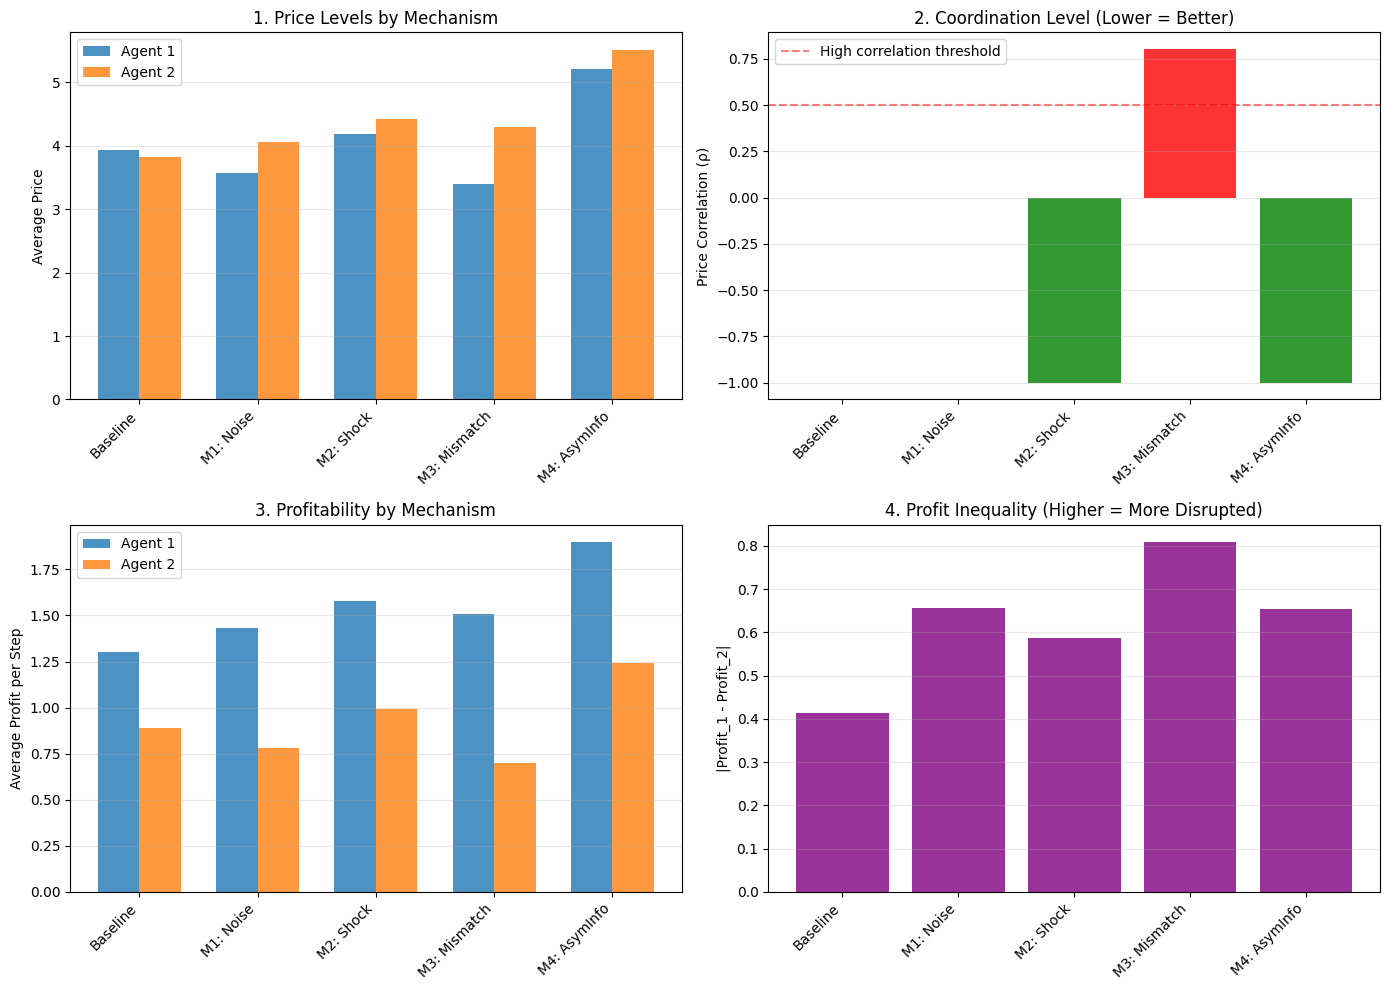


Chart saved successfully!


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Average Prices
ax = axes[0, 0]
x = np.arange(len(df_results))
width = 0.35
ax.bar(x - width/2, df_results['Avg_Price_1'], width, label='Agent 1', alpha=0.8)
ax.bar(x + width/2, df_results['Avg_Price_2'], width, label='Agent 2', alpha=0.8)
ax.set_ylabel('Average Price')
ax.set_title('1. Price Levels by Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Mechanism'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Price Correlation
ax = axes[0, 1]
colors = ['red' if x > 0.5 else 'orange' if x > 0 else 'green' for x in df_results['Price_Correlation']]
ax.bar(x, df_results['Price_Correlation'], color=colors, alpha=0.8)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='High correlation threshold')
ax.set_ylabel('Price Correlation (ρ)')
ax.set_title('2. Coordination Level (Lower = Better)')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Mechanism'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Average Profits
ax = axes[1, 0]
ax.bar(x - width/2, df_results['Avg_Profit_1'], width, label='Agent 1', alpha=0.8)
ax.bar(x + width/2, df_results['Avg_Profit_2'], width, label='Agent 2', alpha=0.8)
ax.set_ylabel('Average Profit per Step')
ax.set_title('3. Profitability by Mechanism')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Mechanism'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 4. Profit Inequality (as proxy for how well collusion is broken)
ax = axes[1, 1]
ax.bar(x, df_results['Profit_Difference'], color='purple', alpha=0.8)
ax.set_ylabel('|Profit_1 - Profit_2|')
ax.set_title('4. Profit Inequality (Higher = More Disrupted)')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Mechanism'], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nChart saved successfully!")

## Pricing Dynamics Over Time

Visualize how prices evolve during evaluation phases for each mechanism.

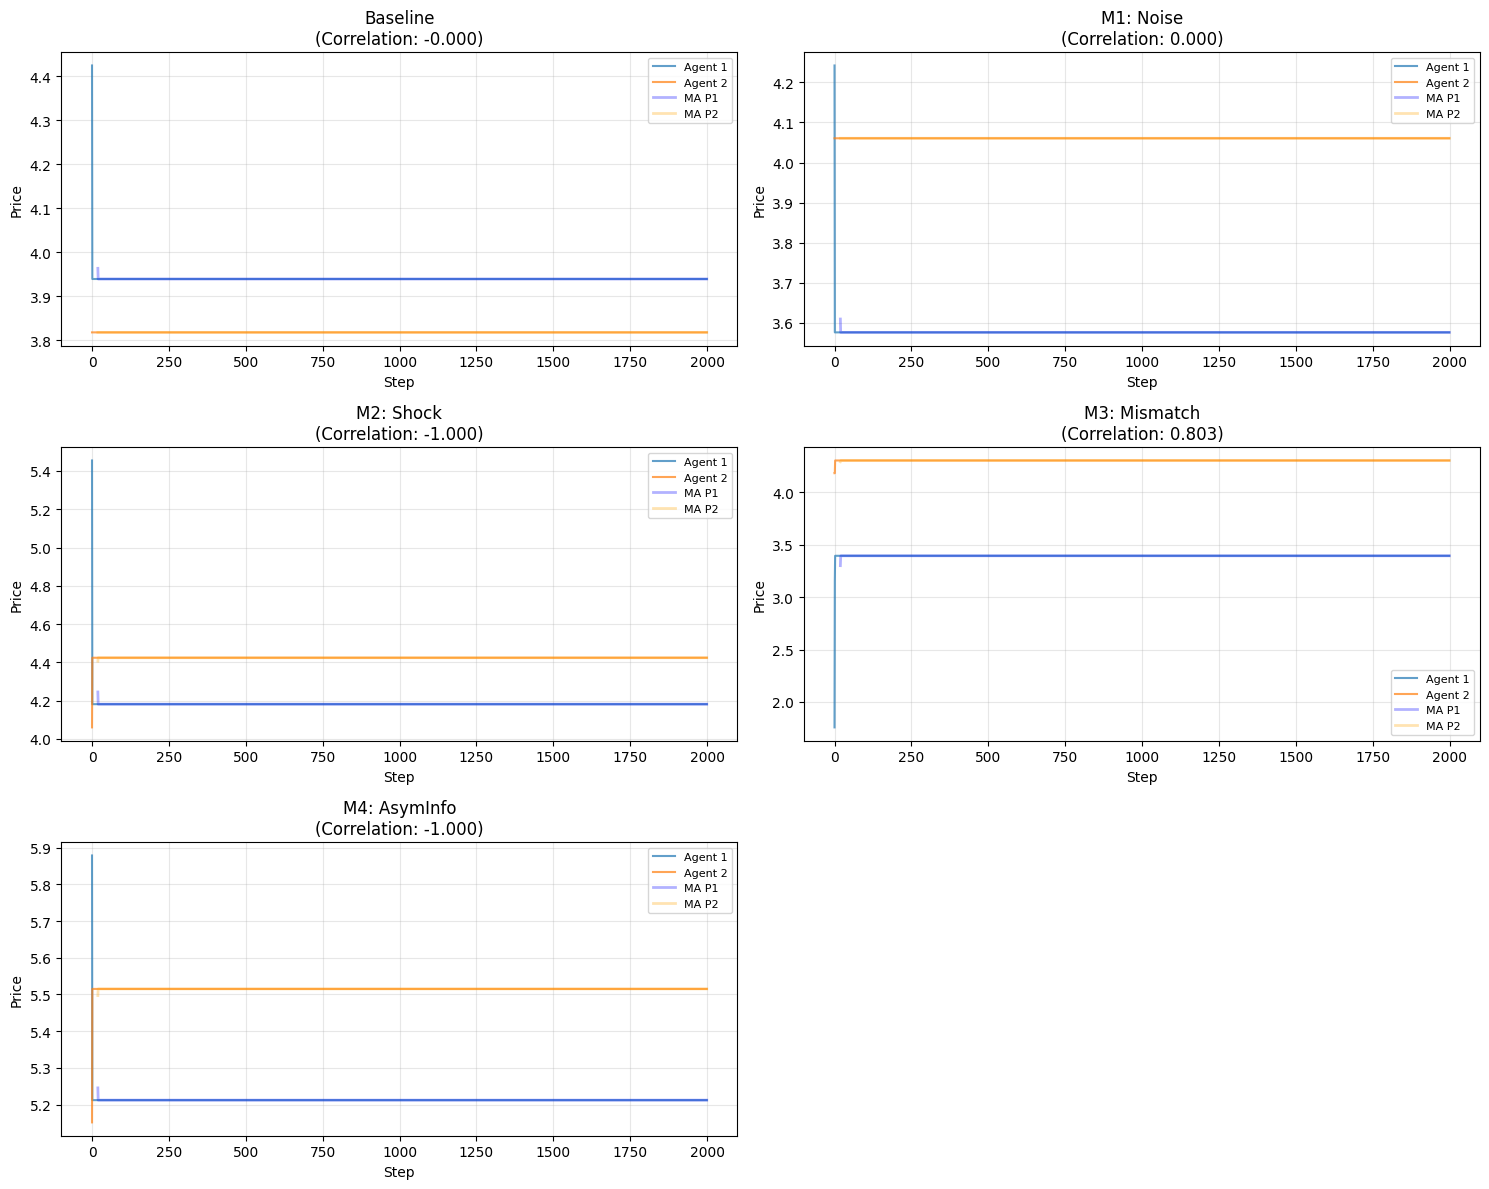

Pricing dynamics visualization complete!


In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
mechanisms = [
    ('Baseline', hist_baseline_eval),
    ('M1: Noise', hist_m1_eval),
    ('M2: Shock', hist_m2_eval),
    ('M3: Mismatch', hist_m3_eval),
    ('M4: AsymInfo', hist_m4_eval),
]

for idx, (name, hist) in enumerate(mechanisms):
    ax = axes[idx // 2, idx % 2]
    
    # Plot prices
    ax.plot(hist['step'], hist['p1'], label='Agent 1', alpha=0.7, linewidth=1.5)
    ax.plot(hist['step'], hist['p2'], label='Agent 2', alpha=0.7, linewidth=1.5)
    
    # Add moving average
    if len(hist) > 20:
        ma_p1 = pd.Series(hist['p1']).rolling(window=20).mean()
        ma_p2 = pd.Series(hist['p2']).rolling(window=20).mean()
        ax.plot(hist['step'], ma_p1, color='blue', linewidth=2, alpha=0.3, label='MA P1')
        ax.plot(hist['step'], ma_p2, color='orange', linewidth=2, alpha=0.3, label='MA P2')
    
    ax.set_title(f'{name}\n(Correlation: {np.corrcoef(hist["p1"], hist["p2"])[0,1]:.3f})')
    ax.set_xlabel('Step')
    ax.set_ylabel('Price')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
axes[2, 1].remove()

plt.tight_layout()
plt.show()

print("Pricing dynamics visualization complete!")